In [1]:
import sys, os, distutils.core
from IPython.display import clear_output

!python -m pip install pyyaml==5.1
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))
clear_output()

In [ ]:
!git clone https://github.com/facebookresearch/detectron2.git

fatal: destination path 'detectron2' already exists and is not an empty directory.


In [ ]:
!pip install fvcore
!pip install omegaconf

In [ ]:
# Importing dependencies

import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
print("detectron2 version:", detectron2.__version__)

import numpy as np
import os, json, cv2, random
from IPython import display
import PIL
import matplotlib.pyplot as plt

# importing detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


SEED = 9
THRESHOLD = 0.3

detectron2 version: 0.6


In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

# Xóa đăng ký dataset cũ nếu tồn tại
for d in ["train", "valid", "test"]:
    dataset_name = f"bone_fractures_{d}"
    if dataset_name in DatasetCatalog:
        DatasetCatalog.remove(dataset_name)
    if dataset_name in MetadataCatalog:
        MetadataCatalog.remove(dataset_name)

# Đăng ký lại với đường dẫn mới
for d in ["train", "valid", "test"]:
    register_coco_instances(
        f"bone_fractures_{d}",
        {},
        f"/content/drive/MyDrive/Dataset/archive/{d}_annotations.coco.json",
        f"/content/BoneFractureYolo8/{d}/images"
    )

In [ ]:
import random
from detectron2.utils.visualizer import Visualizer

my_dataset_train_metadata = MetadataCatalog.get("bone_fractures_train")
train_dataset_dicts = DatasetCatalog.get("bone_fractures_train")

# A function that creates examples from the dataset
def create_random_images(dataset_dict,dataset_metadata, seed, image_scale = 0.7):
    np.random.seed(seed)
    images = np.random.permutation(dataset_dict)[:2]

    fig, axs = plt.subplots(1,2, figsize = (12,6), dpi = 100)
    for i in range(2):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        vis = visualizer.draw_dataset_dict(im)
        final_img = vis.get_image()

        axs[i].set_title('image id: ' + str(img_id), fontsize = 10)
        axs[i].axis('off')
        axs[i].imshow(final_img)

WARNING [03/28 07:32:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/28 07:32:10 d2.data.datasets.coco]: Loaded 3631 images in COCO format from /content/drive/MyDrive/Dataset/archive/train_annotations.coco.json


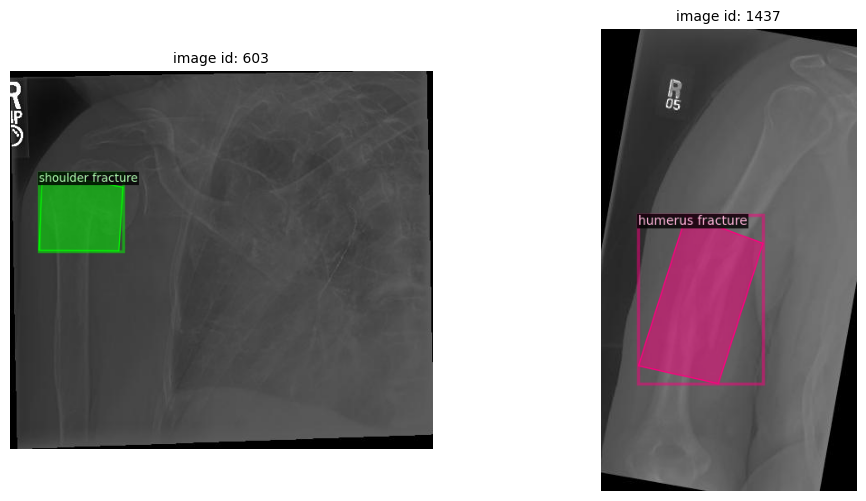

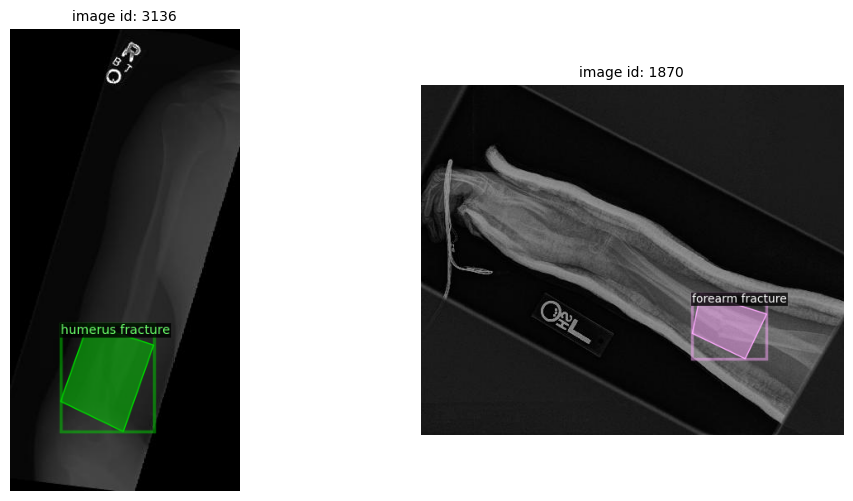

In [ ]:
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 5 , image_scale = 1)
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 9 , image_scale = 1)

In [ ]:
from detectron2.engine import DefaultTrainer

EPOCHS = 1800
NUM_CLASSES = 8
BASE_LR = 0.001

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("bone_fractures_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = EPOCHS
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# uncomment below to train
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/28 07:43:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[03/28 07:43:19 d2.engine.train_loop]: Starting training from iteration 0
[03/28 07:44:02 d2.utils.events]:  eta: 1:06:29  iter: 19  total_loss: 2.479  loss_cls: 2.266  loss_box_reg: 0.01127  loss_rpn_cls: 0.1919  loss_rpn_loc: 0.01182    time: 2.1420  last_time: 2.0776  data_time: 0.0291  last_data_time: 0.0060   lr: 1.9981e-05  max_mem: 10543M
[03/28 07:44:45 d2.utils.events]:  eta: 1:03:40  iter: 39  total_loss: 1.452  loss_cls: 1.291  loss_box_reg: 0.02766  loss_rpn_cls: 0.116  loss_rpn_loc: 0.01033    time: 2.1399  last_time: 1.7634  data_time: 0.0105  last_data_time: 0.0039   lr: 3.9961e-05  max_mem: 10543M
[03/28 07:45:26 d2.utils.events]:  eta: 1:02:55  iter: 59  total_loss: 0.4484  loss_cls: 0.2297  loss_box_reg: 0.0163  loss_rpn_cls: 0.1541  loss_rpn_loc: 0.01313    time: 2.1116  last_time: 2.4082  data_time: 0.0123  last_data_time: 0.0137   lr: 5.9941e-05  max_mem: 10543M
[03/28 07:46:05 d2.utils.events]:  eta: 1:01:09  iter: 79  total_loss: 0.2866  loss_cls: 0.09337  loss_b

In [ ]:
def reading_metrics_from_json(metrics_path):
    metrics = []

    with open(metrics_path, 'r') as f:
        for line in f:
            metrics.append(json.loads(line))
    return metrics


def metric(metrics, specific_metric):
    metric = []
    for i in range(len(metrics)):
        try:
            metric.append(metrics[i][specific_metric])
        except KeyError:
            pass

    return metric

In [ ]:
train_metrics = reading_metrics_from_json('/content/output/metrics.json')

total_loss = metric(train_metrics, 'total_loss')
cls_acc = metric(train_metrics, 'fast_rcnn/cls_accuracy')
false_neg = metric(train_metrics, 'fast_rcnn/false_negative')
loss_box_reg = metric(train_metrics, 'loss_box_reg')
iters = np.arange(1,EPOCHS,EPOCHS/len(total_loss))

Text(0.5, 1.0, 'False Negative')

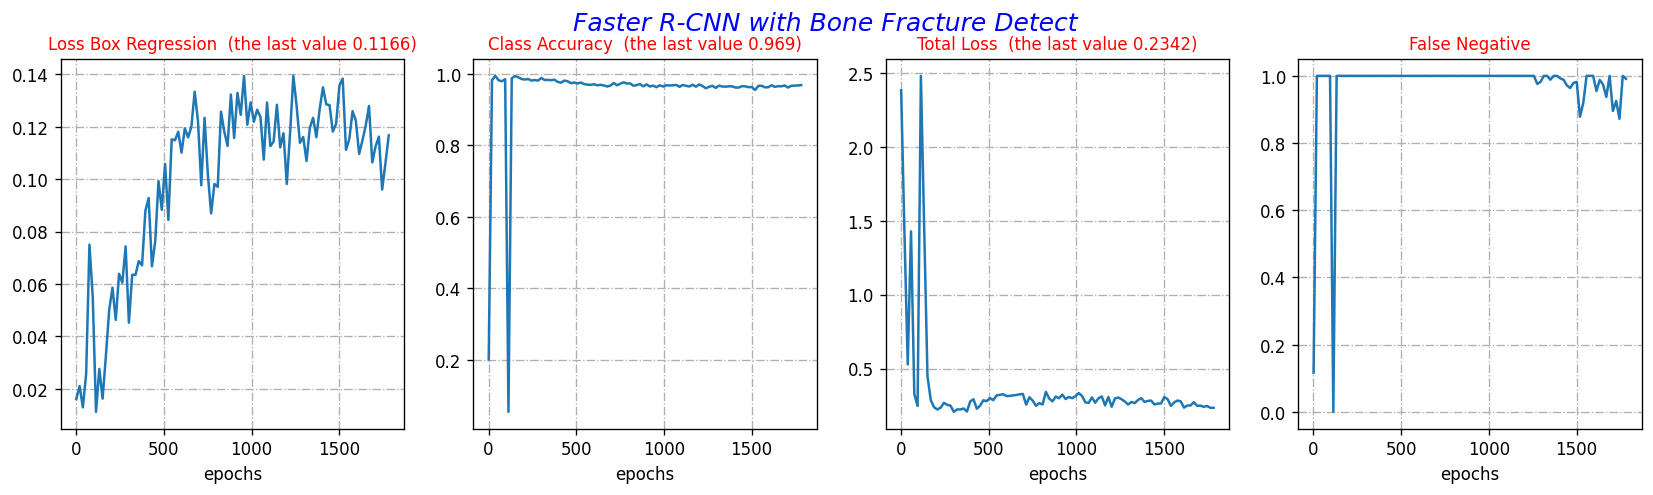

In [ ]:
fig, axs = plt.subplots(1,4, figsize = (17, 4), dpi = 120)
fig.suptitle('Faster R-CNN with Bone Fracture Detect', color = 'blue', fontsize=15,  style = "italic")

axs[0].grid(linestyle = 'dashdot')
axs[0].plot(iters, loss_box_reg)
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].set_title('Loss Box Regression', fontsize = 10)
tit0 = ' (the last value {0:.4f})'.format(loss_box_reg[-1])
axs[0].set_title('Loss Box Regression ' + tit0, fontsize = 10, color = 'red')

axs[1].grid(linestyle = 'dashdot')
axs[1].plot(iters, cls_acc)
axs[1].set_xlabel('epochs', fontsize = 10)
tit1 = ' (the last value {0:.3f})'.format(cls_acc[-1])
axs[1].set_title('Class Accuracy ' + tit1, fontsize = 10, color = 'red')

axs[2].grid(linestyle = 'dashdot')
axs[2].plot(iters, total_loss)
axs[2].set_xlabel('epochs', fontsize = 10)
tit2 = ' (the last value {0:.4f})'.format(total_loss[-1])
axs[2].set_title('Total Loss ' + tit2, fontsize = 10, color = 'red')

axs[3].grid(linestyle = 'dashdot')
axs[3].plot(iters, false_neg)
axs[3].set_xlabel('epochs', fontsize = 10)
axs[3].set_title('False Negative', fontsize = 10, color = 'red')

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("bone_fractures_test", False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "bone_fractures_test")
inference_on_dataset(trainer.model, test_loader, evaluator)

[03/28 08:44:02 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [03/28 08:44:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/28 08:44:02 d2.data.datasets.coco]: Loaded 169 images in COCO format from /content/drive/MyDrive/Dataset/archive/test_annotations.coco.json
[03/28 08:44:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/28 08:44:02 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/28 08:44:02 d2.data.common]: Serializing 169 elements to byte tensors and concatenating them all ...
[03/28 08:44:02 d2.data.common]: Serialized dataset takes 0.05 MiB
[03/28 08:44:02 d2.evaluation.evaluator]: Start inference on 169 batches
[03/28 08:44:05 d2.evaluation.evaluator]: Inference done 11/169

OrderedDict([('bbox',
              {'AP': 5.606028542760832,
               'AP50': 21.338382780428102,
               'AP75': 4.052261453671891,
               'APs': 0.08480766109397825,
               'APm': 5.223946824090786,
               'APl': 8.519137848978112,
               'AP-bones': nan,
               'AP-elbow positive': 3.1814472666331923,
               'AP-fingers positive': 0.9485702692487832,
               'AP-forearm fracture': 11.846825859056494,
               'AP-humerus': nan,
               'AP-humerus fracture': 6.9380050963095545,
               'AP-shoulder fracture': 8.543104943534797,
               'AP-wrist positive': 2.1782178217821775})])

In [ ]:
my_dataset_test_metadata = MetadataCatalog.get("bone_fractures_test")
dataset_dicts = DatasetCatalog.get("bone_fractures_test")

# Initialize the predictor with your trained model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD  # set threshold for this model
# path to the model we just trained
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
predictor = DefaultPredictor(cfg)

# A function for plotting an original image's bbox and predicted bbox
def create_predictions(dataset_dict, dataset_metadata, seed, image_scale = 0.8):
    np.random.seed(seed=seed)
    images = np.random.permutation(dataset_dict)[:3]

    fig, axs = plt.subplots(3,2, figsize = (10,15), dpi = 200)

    for i in range(3):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer1 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)

        vis_original = visualizer1.draw_dataset_dict(im)
        original_bbox = vis_original.get_image()

        visualizer2 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        outputs = predictor(img)
        out = visualizer2.draw_instance_predictions(outputs["instances"].to("cpu"))
        out_img = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
        final_bbox = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)

        axs[i][0].set_title('original bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][0].axis('off')
        axs[i][0].imshow(original_bbox)

        axs[i][1].set_title('predicted bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][1].axis('off')
        axs[i][1].imshow(final_bbox)

WARNING [03/28 08:44:46 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/28 08:44:46 d2.data.datasets.coco]: Loaded 169 images in COCO format from /content/drive/MyDrive/Dataset/archive/test_annotations.coco.json
[03/28 08:44:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


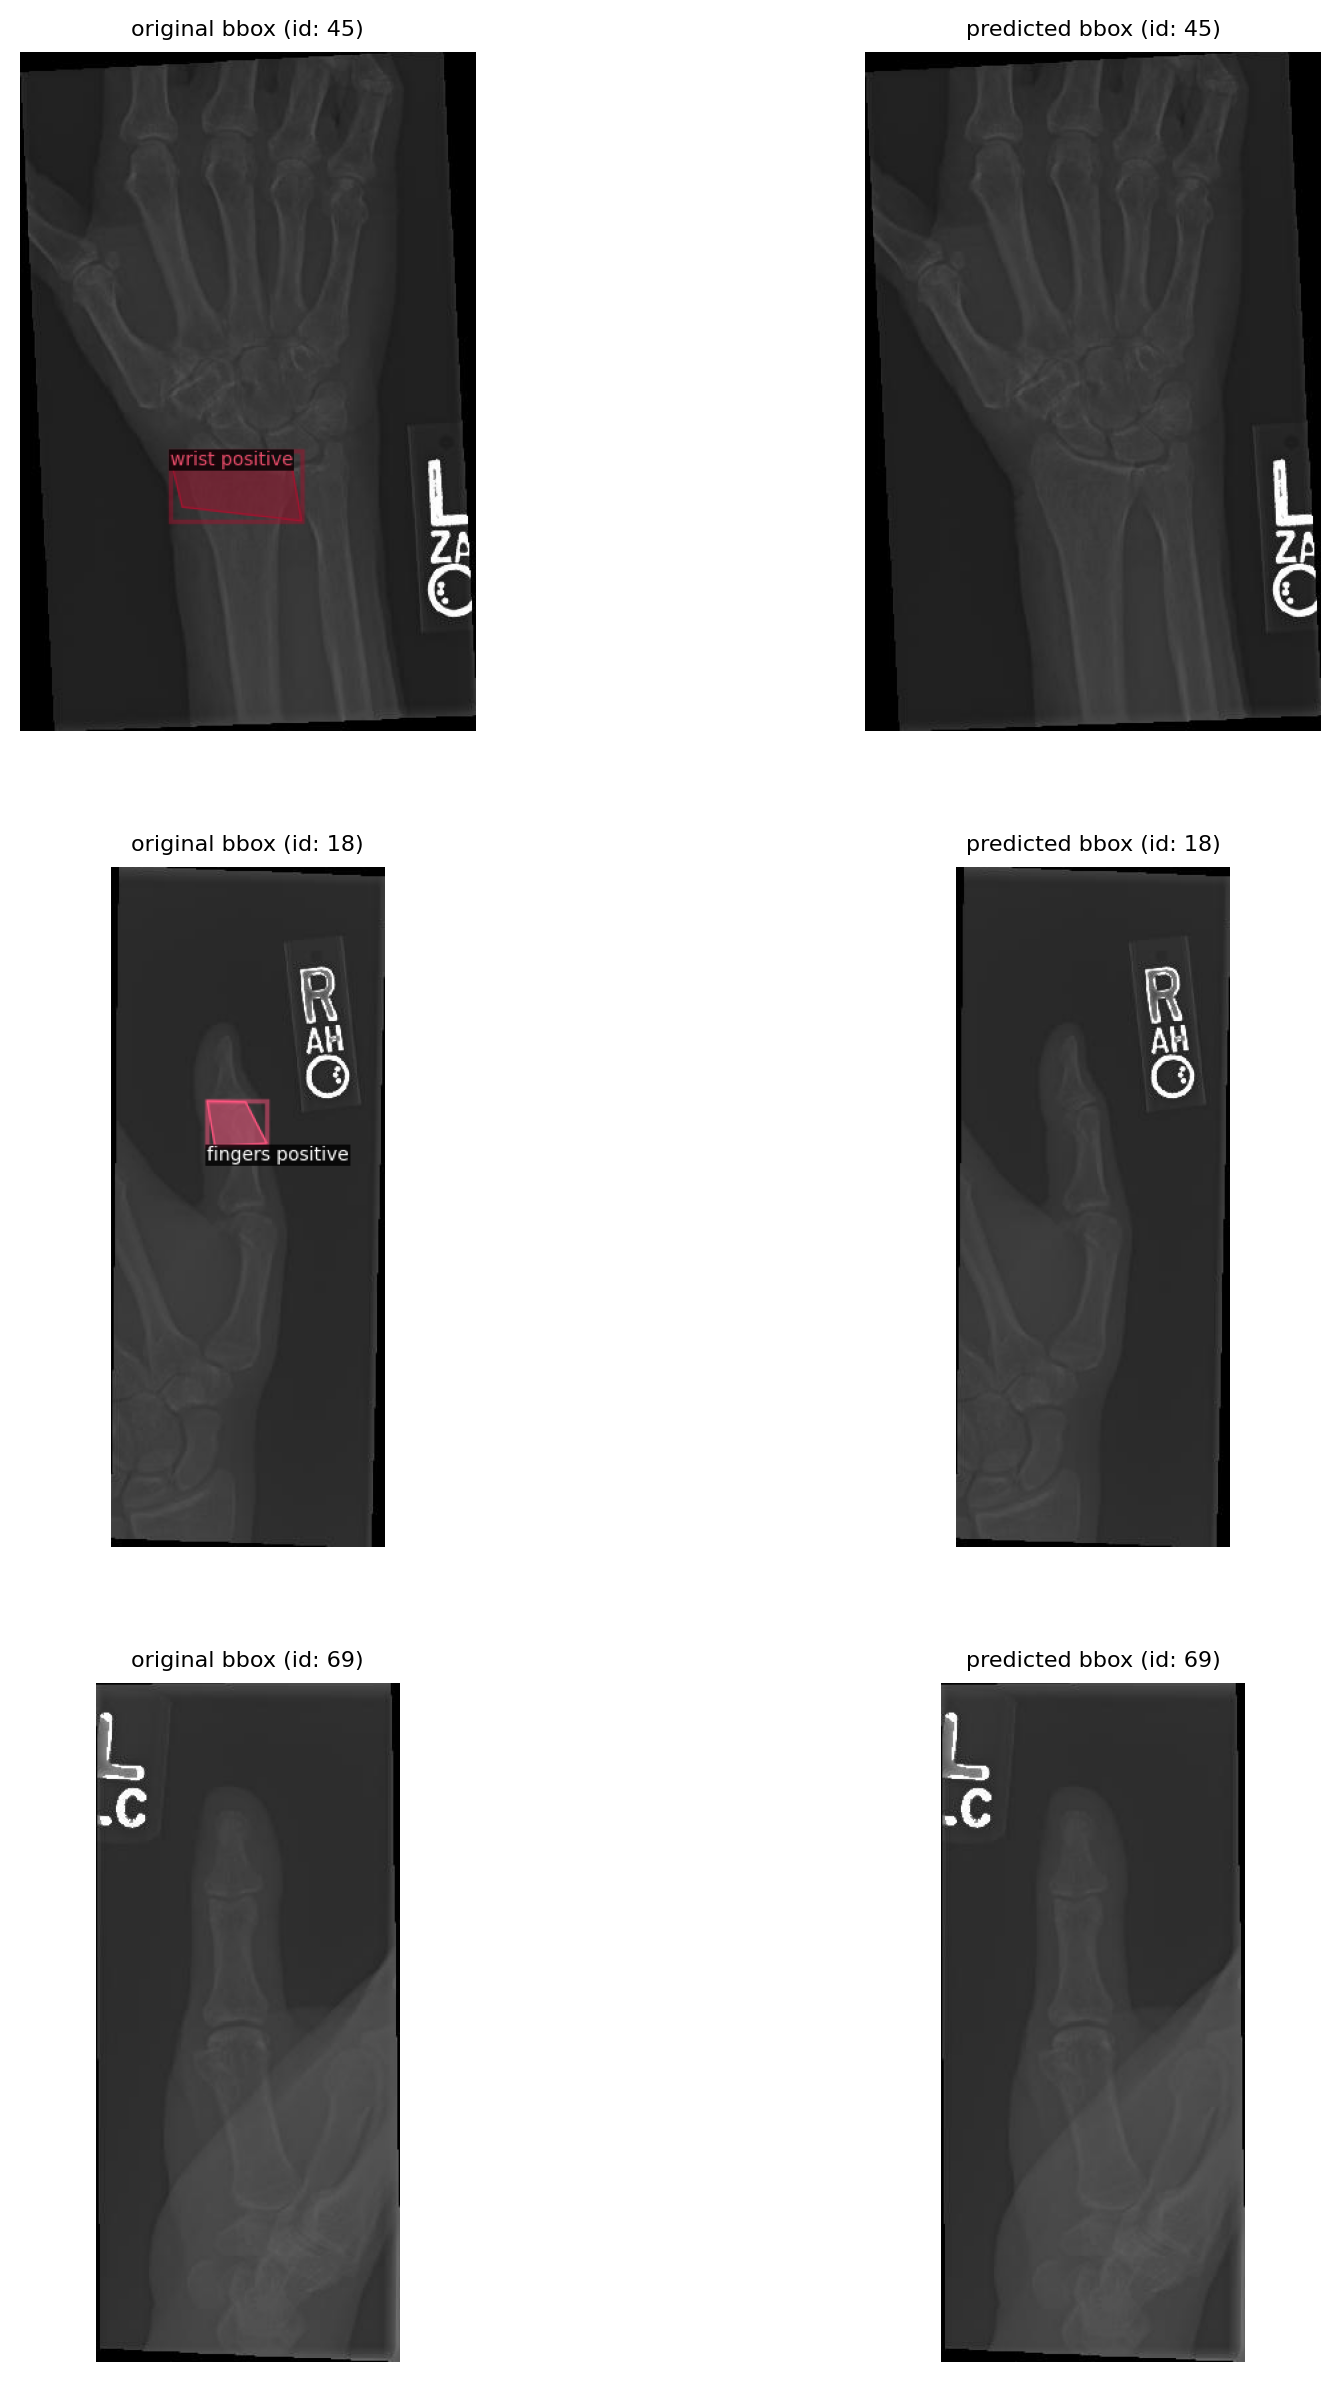

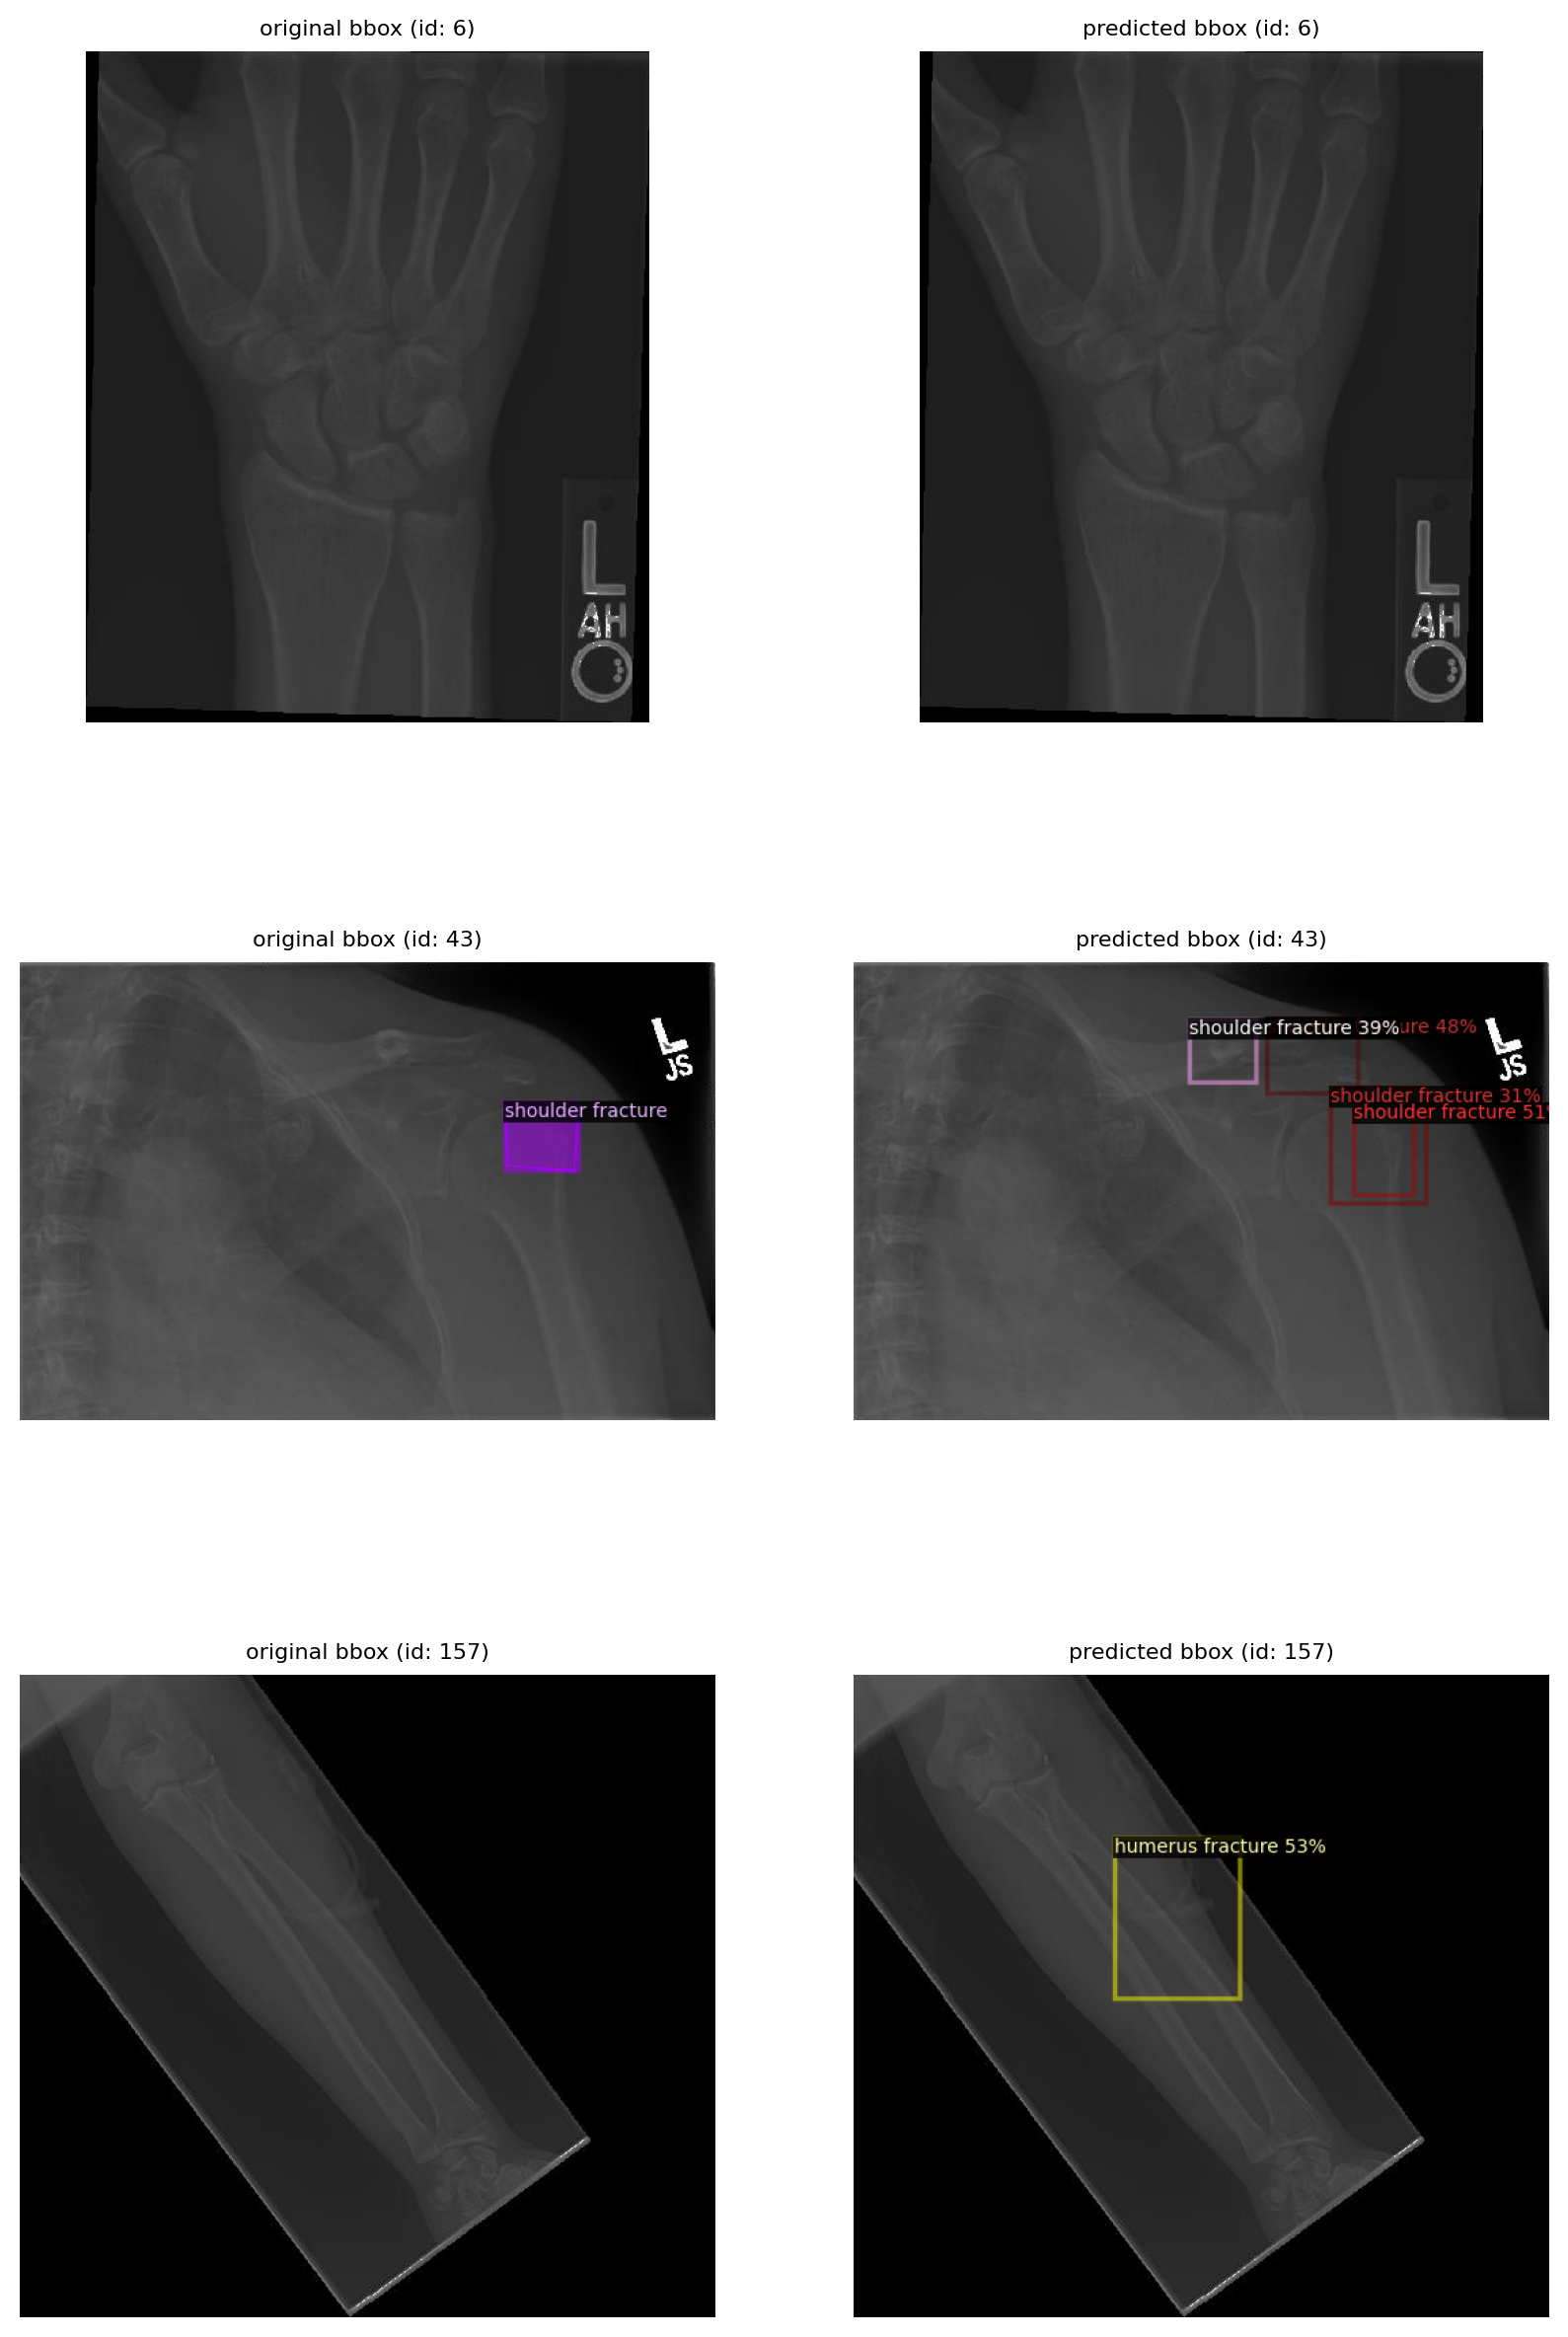

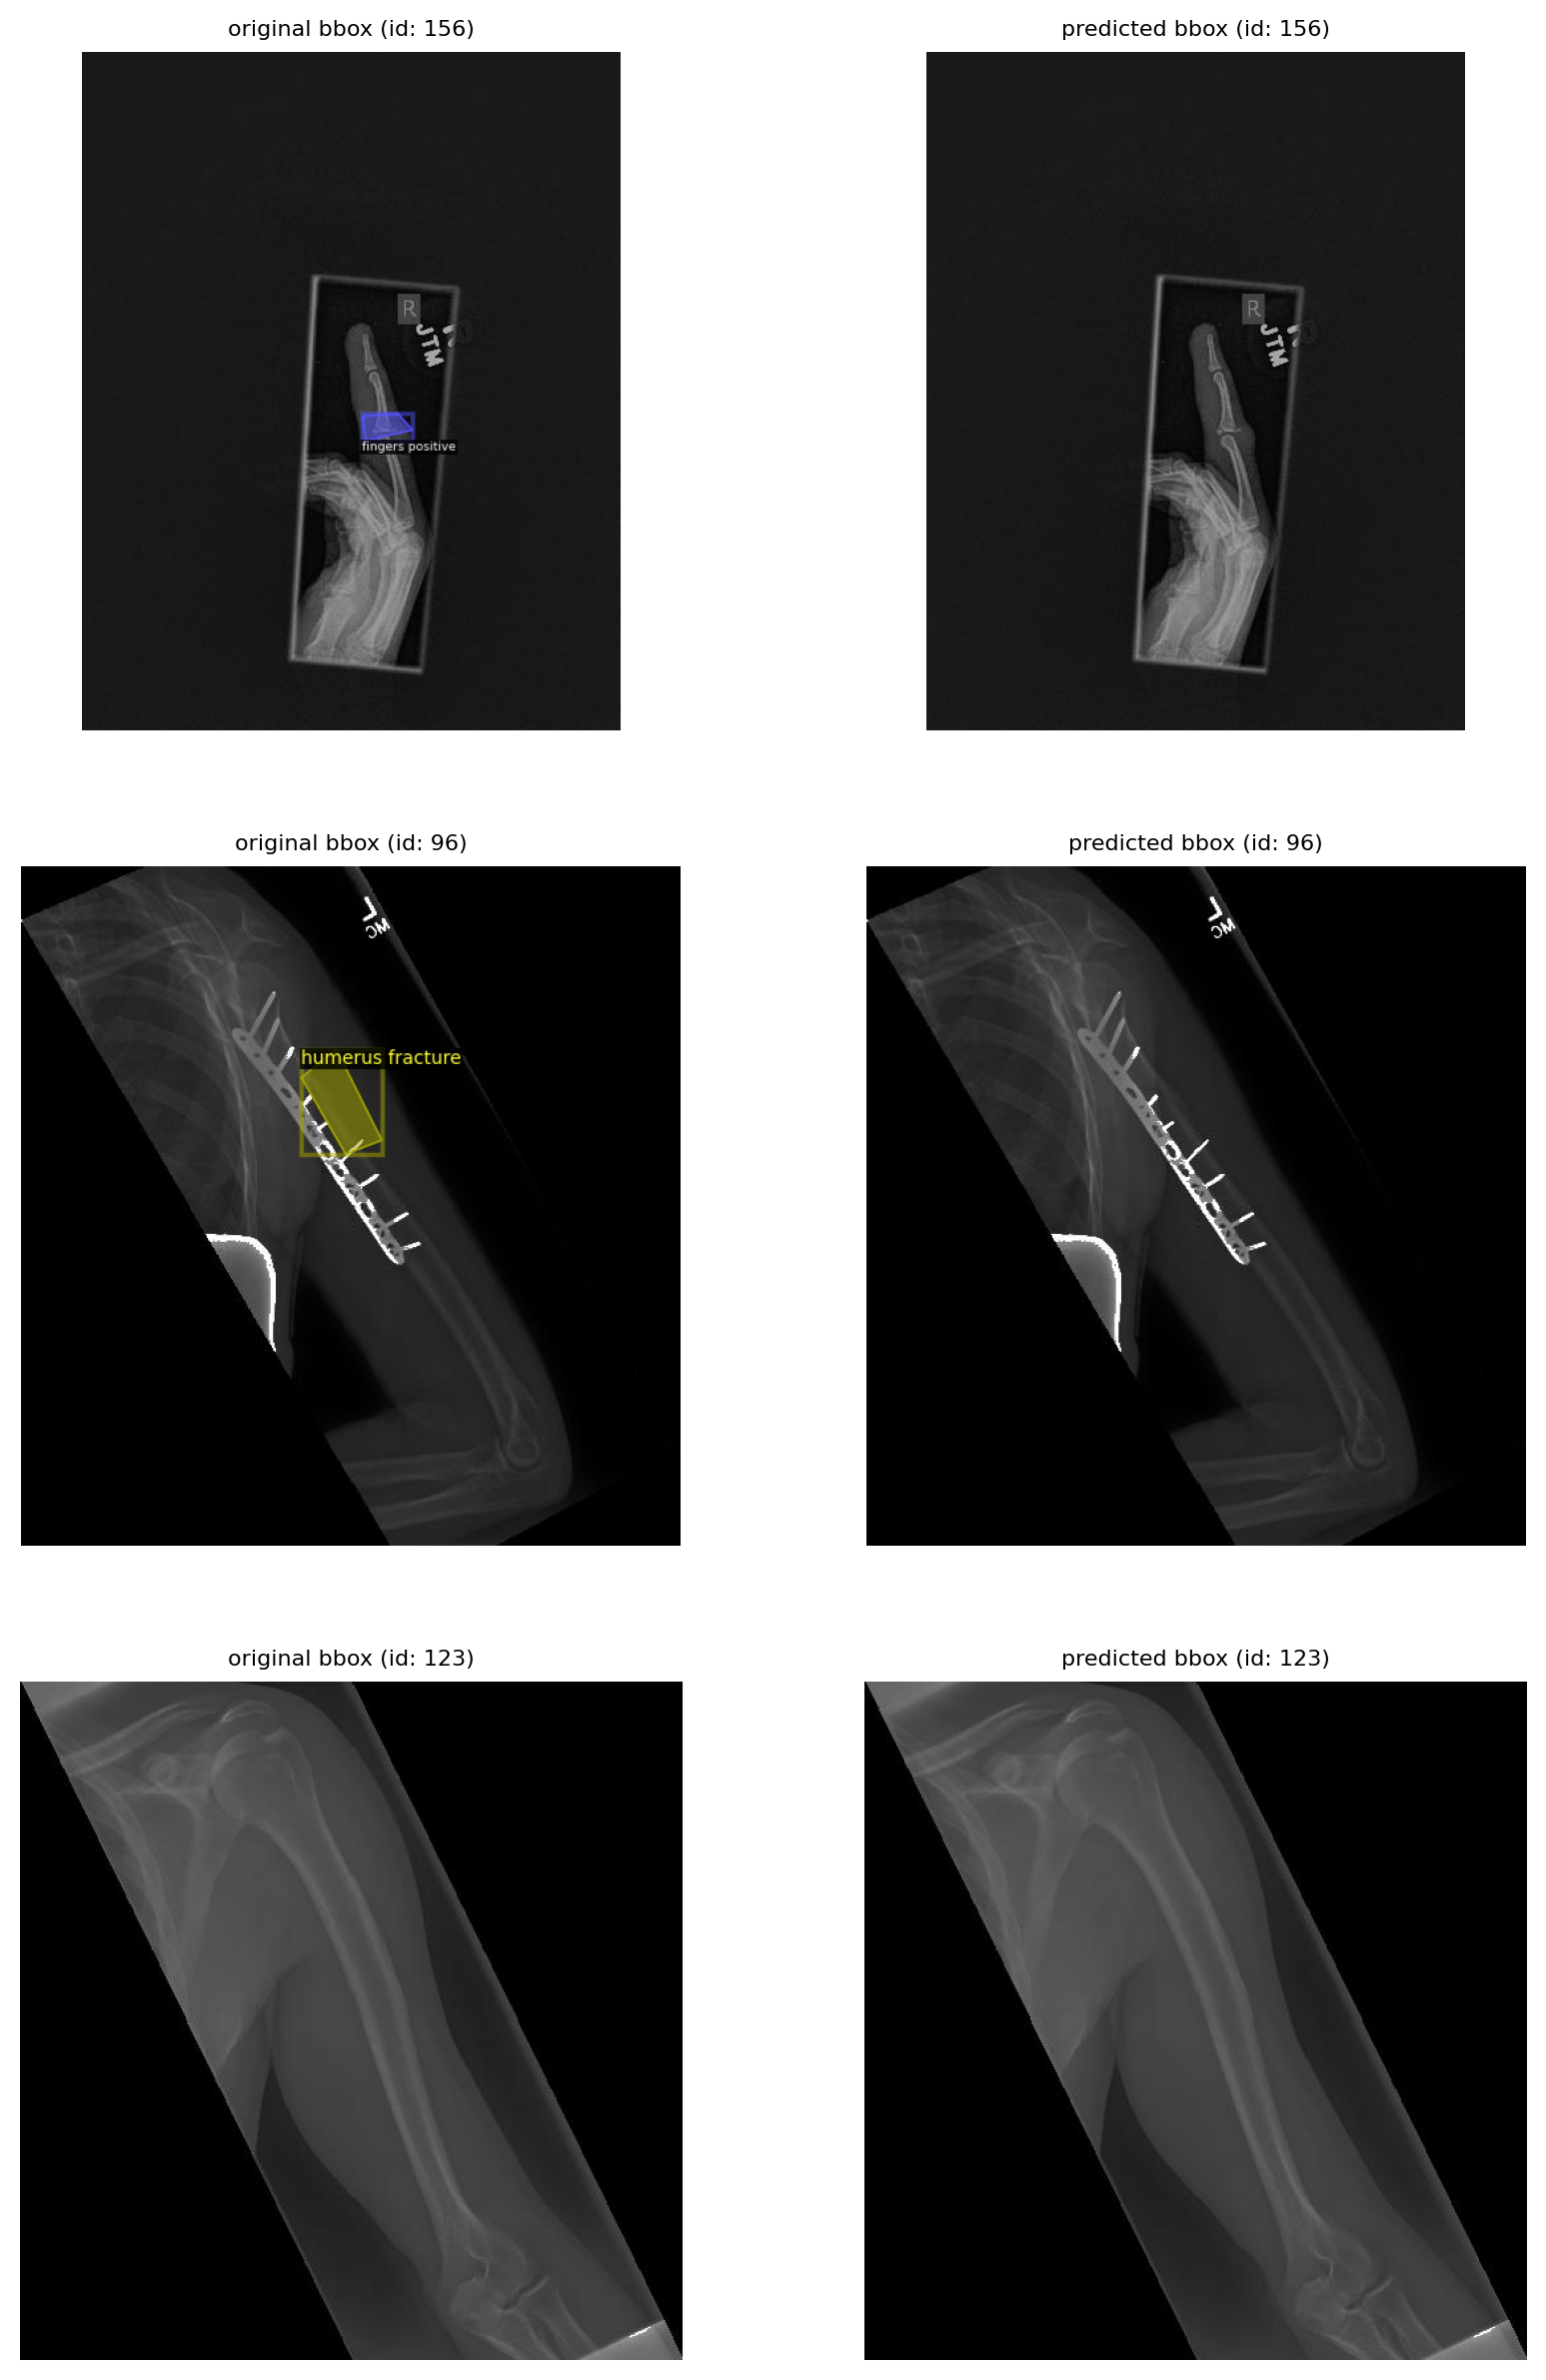

In [ ]:
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 23, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 113, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 433, image_scale=1)

In [ ]:
!zip output

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968